# Comparative Analysis of Sentiment Analysis Techniques

In this project, we will draw comparisons between traditional statistical analysis tools and cutting-edge AI/ML models. This notebook will examine of the capabilities of SAS against models such as the BERT transformer and LSTM (Long Short-Term Memory) networks.

## Objective

The primary aim is to evaluate and contrast the effectiveness of each method in classifying sentiments expressed in a dataset composed of various tweets. This evaluation will focus on metrics such as accuracy, recall, and precision scores to evaluate each method's performance.

## Approach

1. Create "Gold Standard" testing dataset.
2. Import in Tweet Sentiment Extraction train.csv data.
3. Perform Necessary pre-processing.
4. Train a BERT Model and an LSTM Neural Network Model.
5. Test accuracy, precision, and recall on the "Gold Standard" dataset.
6. Analyze results. Explain why one model may work better than others and discuss interpretation of sarcasm and other figurative speech. 

If you are curious about the creation of the Gold Standard dataset, see the file "TestData.ipynb". I will start by importing the necessary libraries and connecting to the Twitter comp_dbms PostgreSQL 

In [29]:
# Import packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Now I will connect to the database and display some basic information about the table twitter.statuses. This is where we will be getting the data which we will perform sentiment analysis on.

In [30]:
df = pd.read_csv('Data/TweetSentimentExtraction.csv', encoding='utf-8')
# Display info
print(f"Num rows: {df.shape[0]}")
df.head()

Num rows: 27481


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [32]:
df.describe()


,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11118


In [33]:
df = df.drop(['textID', 'selected_text'], axis=1)

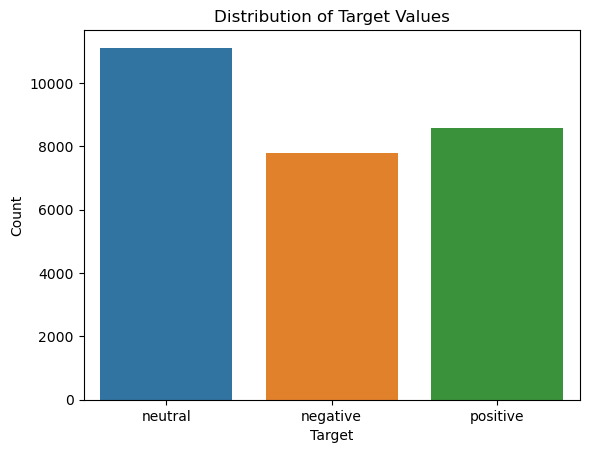

In [34]:
# Plotting the distribution 
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Target Values')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

In [35]:
## set containing all stopwords.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']